In [1]:
# Import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

# Dataset Overview
We'll load the 3D MNIST dataset, which contains 3D voxel representations of digits, and explore its structure.


In [2]:
# Generate synthetic 3D MNIST-like data
def generate_synthetic_data(samples_per_class=100):
    num_classes = 10
    data = []
    labels = []
    for i in range(num_classes):
        data.append(np.random.rand(samples_per_class, 1, 16, 16, 16))  # PyTorch format: (N, C, D, H, W)
        labels.append(np.full(samples_per_class, i))
    return np.concatenate(data), np.concatenate(labels)

X_train, y_train = generate_synthetic_data(samples_per_class=90)
X_test, y_test = generate_synthetic_data(samples_per_class=10)

In [3]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [4]:
# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Class Distribution
Let's examine the distribution of samples across classes in the training dataset.


In [5]:
# Summarize the dataset
df = pd.DataFrame({'Class': np.unique(y_train.numpy()),
                   'Samples': [sum(y_train.numpy() == i) for i in np.unique(y_train.numpy())]})
df['Distribution (%)'] = (df['Samples'] / len(y_train)) * 100

df

,Class,Samples,Distribution (%)
0,0,90,10.0
1,1,90,10.0
2,2,90,10.0
3,3,90,10.0
4,4,90,10.0
5,5,90,10.0
6,6,90,10.0
7,7,90,10.0
8,8,90,10.0
9,9,90,10.0


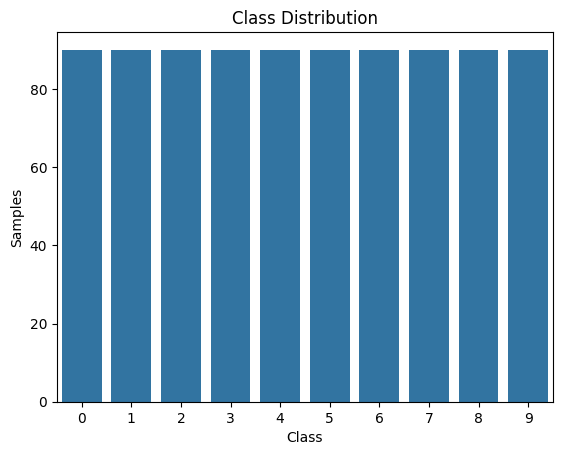

In [6]:
# Plot class distribution
sns.barplot(x='Class', y='Samples', data=df)
plt.title('Class Distribution')
plt.show()

# Dataset Overview



### Sample Exploration
We'll visualize a few samples using 2D projections along different axes and an interactive 3D visualization.


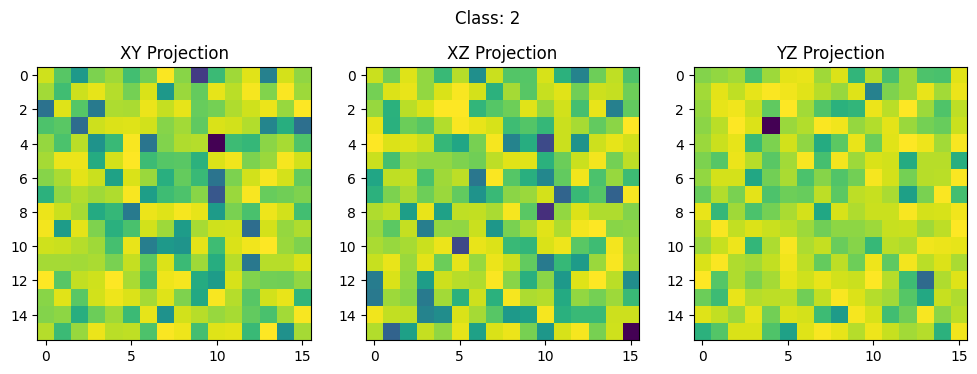

In [7]:
# Display a random sample with projections
sample_idx = np.random.randint(0, len(X_train))
volume = X_train[sample_idx].numpy()
label = y_train[sample_idx].item()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(np.max(volume, axis=1).squeeze(), cmap='viridis')  # Max along depth
axes[0].set_title('XY Projection')
axes[1].imshow(np.max(volume, axis=2).squeeze(), cmap='viridis')  # Max along height
axes[1].set_title('XZ Projection')
axes[2].imshow(np.max(volume, axis=3).squeeze(), cmap='viridis')  # Max along width
axes[2].set_title('YZ Projection')
plt.suptitle(f"Class: {label}")
plt.show()

In [8]:
# Interactive 3D visualization
def visualize_3d(volume, label):
    x, y, z = np.mgrid[:16, :16, :16]
    fig = go.Figure(data=go.Volume(
        x=x.flatten(), y=y.flatten(), z=z.flatten(),
        value=volume.flatten(),
        opacity=0.1, surface_count=20,
        colorscale="Viridis"
    ))
    fig.update_layout(
        title=f"3D Visualization: Class {label}",
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")
    )
    fig.show()

visualize_3d(volume.squeeze(), label)

### Model Architecture
We'll define a 3D convolutional neural network and display its architecture.


In [9]:
# Define a very basic CNN model
class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=1)  # Keeps input size same
        self.pool = nn.MaxPool3d(2)  # Halves spatial dimensions
        self.fc = nn.Linear(16 * 8 * 8 * 8, 10)  # Matches flattened size

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Convolution + Pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # Fully connected layer
        return x
    
# Instantiate the model
model = Simple3DCNN()
print(model)

Simple3DCNN(
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=8192, out_features=10, bias=True)
)


In [10]:
# Test with synthetic input
sample_input = torch.randn(8, 1, 16, 16, 16)  # Batch of 8 samples with 1 channel
output = model(sample_input)
print(output.shape)  # Output should be [8, 10], where 10 is the number of classes

torch.Size([8, 10])


In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Model Training
We'll train the model and monitor accuracy and loss in real-time.


In [12]:
# # Training loop
# def train_model(model, train_loader, criterion, optimizer, epochs=10):
#     model.train()
#     train_losses = []
#     for epoch in range(epochs):
#         running_loss = 0.0
#         for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         epoch_loss = running_loss / len(train_loader)
#         train_losses.append(epoch_loss)
#         print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")
#     return train_losses

# train_losses = train_model(model, train_loader, criterion, optimizer)

# Training loop with accuracy tracking
def train_model_with_metrics(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    return train_losses, train_accuracies

# Train the model and collect metrics
train_losses, train_accuracies = train_model_with_metrics(model, train_loader, criterion, optimizer, epochs=10)



Epoch 1/10:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 1, Loss: 2.4676, Accuracy: 0.1067


Epoch 2/10:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 2, Loss: 2.2693, Accuracy: 0.1556


Epoch 3/10:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 3, Loss: 2.1193, Accuracy: 0.3500


Epoch 4/10:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 4, Loss: 1.9423, Accuracy: 0.3822


Epoch 5/10:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 5, Loss: 1.6708, Accuracy: 0.6444


Epoch 6/10:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 6, Loss: 1.4699, Accuracy: 0.7356


Epoch 7/10:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 7, Loss: 1.2173, Accuracy: 0.8333


Epoch 8/10:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 8, Loss: 0.9572, Accuracy: 0.9500


Epoch 9/10:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 9, Loss: 0.7419, Accuracy: 0.9711


Epoch 10/10:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 10, Loss: 0.5952, Accuracy: 0.9867


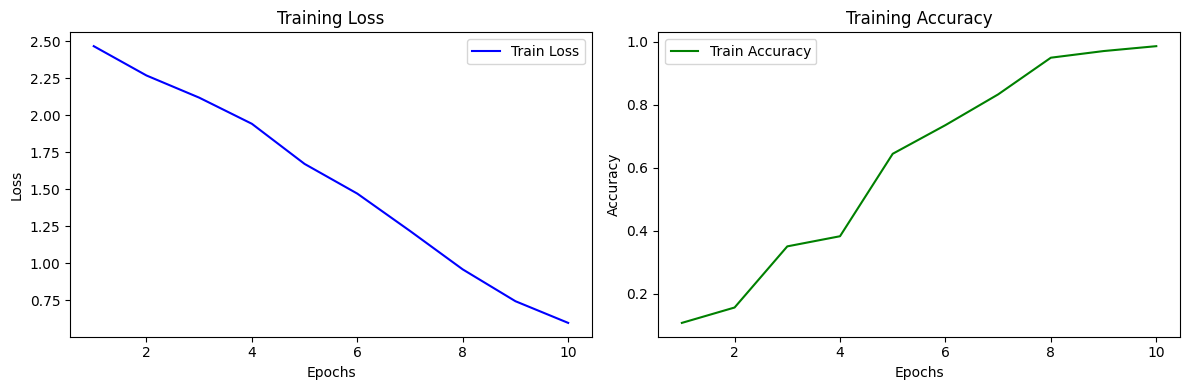

In [17]:
# Plot training loss and accuracy
def plot_metrics(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss plot
    ax1.plot(epochs, train_losses, label='Train Loss', color='blue')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy plot
    ax2.plot(epochs, train_accuracies, label='Train Accuracy', color='green')
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(train_losses, train_accuracies)


In [18]:
# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

predictions, true_labels = evaluate_model(model, test_loader)


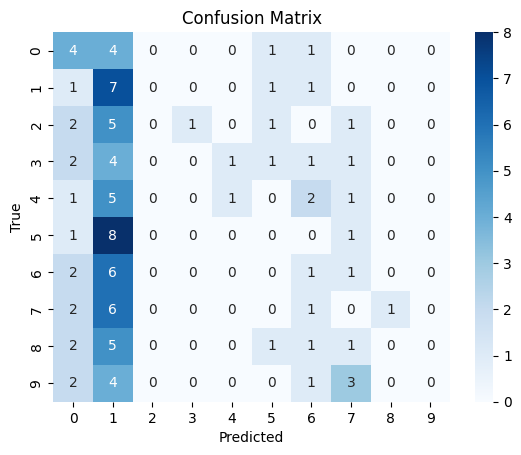

In [19]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
# Display misclassified samples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(true_labels, predictions)) if true != pred]
for idx in misclassified_indices[:3]:  # Show up to 3 misclassified samples
    volume = X_test[idx].numpy()
    true_label = y_test[idx].item()
    predicted_label = predictions[idx]
    visualize_3d(volume.squeeze(), true_label)
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")

True Label: 0, Predicted Label: 6


True Label: 0, Predicted Label: 1


True Label: 0, Predicted Label: 1
